<a href="https://colab.research.google.com/github/yfukui47/course2021-sml/blob/main/%E8%A1%A8%E6%83%85%E6%8E%A8%E5%AE%9A%E7%B2%BE%E5%BA%A6%E7%A2%BA%E8%AA%8D(2_%E5%96%9C%E3%81%A8%E3%81%9D%E3%82%8C%E4%BB%A5%E5%A4%96).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 音声による表情推定分類器

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [4]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

## プロトタイプ出力CSVファイルの加工

### データ読み込み

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np

再実行の場合はここから

In [121]:
# ファイル読み込み
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_5f_3s.csv")   ## 精度: 0.50794 / ２分類
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_5f_5s.csv")   ## 精度: 0.68254 / ２分類
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_5f_7s.csv")   ## 精度: 0.70588 / 1分類 NG
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_5f_10s.csv")  ## 精度: 0.55556 / ２分類

# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_10f_3s.csv")  ## 精度: 0.61905 / ２分類
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_10f_5s.csv")  ## 精度: 0.47619 / 1分類 NG
df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_10f_7s.csv")  ## 精度: 0.70588 / ２分類
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_10f_10s.csv") ## 精度: 0.75000 / ２分類

# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_20f_3s.csv")  ## 精度: 0.60317 / ２分類
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_20f_5s.csv")  ## 精度: 0.49206 / ２分類
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_20f_7s.csv")  ## 精度: 0.72549 / 1分類 NG
# df = pd.read_csv("/content/drive/MyDrive/表情/ CSV/output_20f_10s.csv") ## 精度: 0.77778 / ２分類  ★

df.head(3)

,filename,fps,timestamp,smile_flg,smile_confidence,primalExpression,calm,sad,confused,fear,...,original_duration,balance,f0_mean,f0_std,f0_median,f0_min,f0_max,f0_quantile25,f0_quan75,result_flg
0,FFQFAKXyRCU,10,0:00:00,False,94.755348,1,88.602562,2.179124,9.866685,5.925173,...,10.0,0.8,150.06,78.8,121.3,79.0,406.0,95.0,172.0,True
1,FFQFAKXyRCU,10,0:00:00.100000,False,94.717186,1,89.892105,2.185883,8.393709,5.948472,...,10.0,0.8,150.06,78.8,121.3,79.0,406.0,95.0,172.0,True
2,FFQFAKXyRCU,10,0:00:00.200000,False,94.736214,1,89.737099,2.179730,8.402431,5.941079,...,10.0,0.8,150.06,78.8,121.3,79.0,406.0,95.0,172.0,True


In [122]:
#行列数の確認
df.shape

(9030, 41)

In [123]:
print(df.isnull().any())

filename               False
fps                    False
timestamp              False
smile_flg              False
smile_confidence       False
primalExpression       False
calm                   False
sad                    False
confused               False
fear                   False
angry                  False
disgusted              False
surprised              False
happy                  False
AgeRange               False
Eyeglasses             False
Gender                 False
Mustache               False
Sunglasses             False
row_no                 False
talk_length            False
positive               False
negative               False
neutral                False
mixed                  False
non_negative           False
number_of_syllables     True
number_of_pauses        True
rate_of_speech          True
articulation_rate       True
speaking_duration       True
original_duration       True
balance                 True
f0_mean                 True
f0_std        

In [124]:
print(df.isnull().sum())

filename                0
fps                     0
timestamp               0
smile_flg               0
smile_confidence        0
primalExpression        0
calm                    0
sad                     0
confused                0
fear                    0
angry                   0
disgusted               0
surprised               0
happy                   0
AgeRange                0
Eyeglasses              0
Gender                  0
Mustache                0
Sunglasses              0
row_no                  0
talk_length             0
positive                0
negative                0
neutral                 0
mixed                   0
non_negative            0
number_of_syllables    70
number_of_pauses       70
rate_of_speech         70
articulation_rate      70
speaking_duration      70
original_duration      70
balance                70
f0_mean                70
f0_std                 70
f0_median              70
f0_min                 70
f0_max                 70
f0_quantile2

In [125]:
df.dtypes

filename                object
fps                      int64
timestamp               object
smile_flg                 bool
smile_confidence       float64
primalExpression         int64
calm                   float64
sad                    float64
confused               float64
fear                   float64
angry                  float64
disgusted              float64
surprised              float64
happy                  float64
AgeRange                object
Eyeglasses                bool
Gender                  object
Mustache                  bool
Sunglasses                bool
row_no                   int64
talk_length              int64
positive               float64
negative               float64
neutral                float64
mixed                  float64
non_negative           float64
number_of_syllables    float64
number_of_pauses       float64
rate_of_speech         float64
articulation_rate      float64
speaking_duration      float64
original_duration      float64
balance 

In [126]:
df.dropna(inplace=True)

In [127]:
df.columns

Index(['filename', 'fps', 'timestamp', 'smile_flg', 'smile_confidence',
       'primalExpression', 'calm', 'sad', 'confused', 'fear', 'angry',
       'disgusted', 'surprised', 'happy', 'AgeRange', 'Eyeglasses', 'Gender',
       'Mustache', 'Sunglasses', 'row_no', 'talk_length', 'positive',
       'negative', 'neutral', 'mixed', 'non_negative', 'number_of_syllables',
       'number_of_pauses', 'rate_of_speech', 'articulation_rate',
       'speaking_duration', 'original_duration', 'balance', 'f0_mean',
       'f0_std', 'f0_median', 'f0_min', 'f0_max', 'f0_quantile25', 'f0_quan75',
       'result_flg'],
      dtype='object')

In [128]:
print('calm : ' + str(df['calm'].sum()))
print('sad  : ' + str(df['sad'].sum()))
print('confused : ' + str(df['confused'].sum()))
print('fear :' + str(df['fear'].sum()))
print('angry  :' + str(df['angry'].sum()))
print('disgusted : ' + str(df['disgusted'].sum()))
print('surprised :' + str(df['surprised'].sum()))
print('happy  :' + str(df['happy'].sum()))

calm : 417716.16335795075
sad  : 24702.631155252457
confused : 338783.5075135082
fear :60522.23049736023
angry  :15188.361362971365
disgusted : 35311.621327742934
surprised :90429.29935598373
happy  :13835.355259204283


In [129]:
#表情別AI推定量合計
name = ['calm', 'sad', 'confused', 'fear', 'angry','disgusted', 'surprised', 'happy']
score = [df['calm'].sum()/1000
          ,df['sad'].sum()/1000
          ,df['confused'].sum()/1000
          ,df['fear'].sum()/1000
          ,df['angry'].sum()/1000
          ,df['disgusted'].sum()/1000
          ,df['surprised'].sum()/1000
          ,df['happy'].sum()/1000]
df_count = pd.DataFrame(score,index=name) 


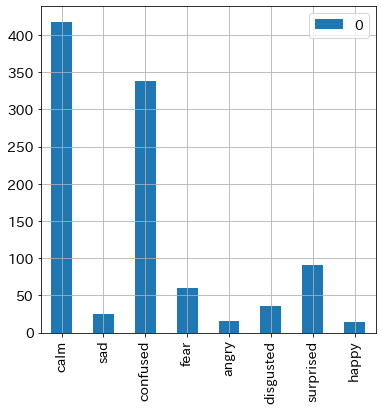

In [130]:
df_count.plot.bar()   

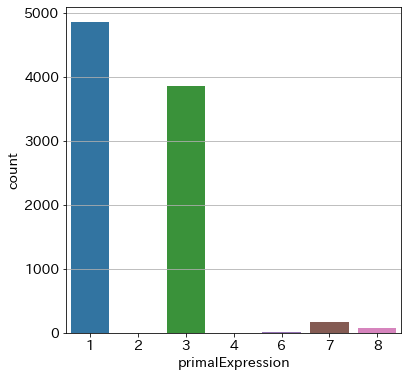

In [131]:
#正解ラベル数比較
import seaborn as sns
sns.countplot(x="primalExpression", data=df)

In [132]:
result = df.groupby(['positive','negative', 'neutral', 'mixed', 'non_negative','number_of_syllables',
                     'number_of_pauses', 'rate_of_speech', 'articulation_rate',
                     'speaking_duration', 'original_duration', 'balance', 'f0_mean',
                     'f0_std', 'f0_median', 'f0_min', 'f0_max', 'f0_quantile25', 'f0_quan75']).mean().reset_index()
                    #  'f0_std', 'f0_median', 'f0_min', 'f0_max', 'f0_quantile25', 'f0_quan75'], as_index=False)

result.shape

(128, 37)

In [133]:
result.head()

,positive,negative,neutral,mixed,non_negative,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,...,angry,disgusted,surprised,happy,Eyeglasses,Mustache,Sunglasses,row_no,talk_length,result_flg
0,0.000150,0.001103,0.998741,0.000006,0.998897,19.0,1.0,4.0,5.0,3.9,...,1.162335,3.726363,7.403264,1.057426,0.928571,0.0,0.0,4.0,40.0,1.0
1,0.000201,0.860960,0.138764,0.000075,0.139040,27.0,5.0,3.0,4.0,6.1,...,3.187314,5.164883,10.153709,2.103233,1.000000,0.0,0.0,115.0,61.0,1.0
2,0.000217,0.000166,0.999613,0.000005,0.999834,18.0,3.0,3.0,4.0,4.1,...,1.199638,3.676051,7.289922,0.552628,0.928571,0.0,0.0,13.0,39.0,1.0
3,0.000275,0.968899,0.027058,0.003768,0.031101,21.0,4.0,3.0,4.0,5.3,...,2.068666,7.652417,12.320524,1.736997,0.971429,0.0,0.0,22.0,50.0,1.0
4,0.000372,0.020208,0.977962,0.001458,0.979792,23.0,2.0,4.0,5.0,4.6,...,1.314073,3.016328,7.801524,0.470987,0.971429,0.0,0.0,23.0,31.0,1.0


In [134]:
result.columns

Index(['positive', 'negative', 'neutral', 'mixed', 'non_negative',
       'number_of_syllables', 'number_of_pauses', 'rate_of_speech',
       'articulation_rate', 'speaking_duration', 'original_duration',
       'balance', 'f0_mean', 'f0_std', 'f0_median', 'f0_min', 'f0_max',
       'f0_quantile25', 'f0_quan75', 'fps', 'smile_flg', 'smile_confidence',
       'primalExpression', 'calm', 'sad', 'confused', 'fear', 'angry',
       'disgusted', 'surprised', 'happy', 'Eyeglasses', 'Mustache',
       'Sunglasses', 'row_no', 'talk_length', 'result_flg'],
      dtype='object')

In [135]:
result['recoginition_Sum1'] = result['happy'] + result['surprised']
result['recoginition_Sum2'] = result['fear'] + result['angry']
result['recoginition_Sum3'] = result['sad'] + result['disgusted']
result['recoginition_Sum'] = result['happy'] + result['surprised'] + result['sad'] + result['disgusted'] + result['fear'] + result['angry'] + result['calm'] + result['confused']

In [136]:
#正解ラベル準備
#sad
result.loc[(result['recoginition_Sum3']%result['recoginition_Sum'] > 5) | (result['negative'] > 0.3), 'Answer'] = 2
#fear
result.loc[(result['recoginition_Sum2']%result['recoginition_Sum'] > 6) & (result['negative'] > 0.3), 'Answer'] = 4
#disgusted
result.loc[(result['recoginition_Sum3']%result['recoginition_Sum'] > 6) & (result['negative'] > 0.3), 'Answer'] = 6
#angry
result.loc[(result['recoginition_Sum2']%result['recoginition_Sum'] > 9) & (result['negative'] > 0.5), 'Answer'] = 5
#Surprised
result.loc[(result['recoginition_Sum1']%result['recoginition_Sum'] > 3) & (result['positive'] > 0.1), 'Answer'] = 7
#Happy
result.loc[(result['recoginition_Sum1']%result['recoginition_Sum'] > 12) | (result['positive'] > 0.25), 'Answer'] = 8
# result.loc[(result['recoginition_Sum1']%result['recoginition_Sum'] > 6) & (result['positive'] > 0.15), 'Answer'] = 8
#Calm
result.loc[(result['calm']> 75) | (result['neutral'] > 0.75), 'Answer'] = 1
#Confused
result.loc[(result['confused']> 50) | (result['mixed'] > 0.1), 'Answer'] = 3


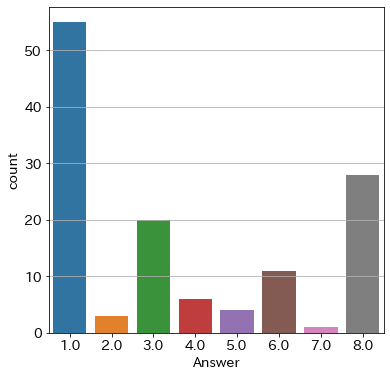

In [137]:
sns.countplot(x="Answer", data=result)

In [138]:
print(result.isnull().sum())

positive               0
negative               0
neutral                0
mixed                  0
non_negative           0
number_of_syllables    0
number_of_pauses       0
rate_of_speech         0
articulation_rate      0
speaking_duration      0
original_duration      0
balance                0
f0_mean                0
f0_std                 0
f0_median              0
f0_min                 0
f0_max                 0
f0_quantile25          0
f0_quan75              0
fps                    0
smile_flg              0
smile_confidence       0
primalExpression       0
calm                   0
sad                    0
confused               0
fear                   0
angry                  0
disgusted              0
surprised              0
happy                  0
Eyeglasses             0
Mustache               0
Sunglasses             0
row_no                 0
talk_length            0
result_flg             0
recoginition_Sum1      0
recoginition_Sum2      0
recoginition_Sum3      0


In [139]:
# result = []
result.columns

Index(['positive', 'negative', 'neutral', 'mixed', 'non_negative',
       'number_of_syllables', 'number_of_pauses', 'rate_of_speech',
       'articulation_rate', 'speaking_duration', 'original_duration',
       'balance', 'f0_mean', 'f0_std', 'f0_median', 'f0_min', 'f0_max',
       'f0_quantile25', 'f0_quan75', 'fps', 'smile_flg', 'smile_confidence',
       'primalExpression', 'calm', 'sad', 'confused', 'fear', 'angry',
       'disgusted', 'surprised', 'happy', 'Eyeglasses', 'Mustache',
       'Sunglasses', 'row_no', 'talk_length', 'result_flg',
       'recoginition_Sum1', 'recoginition_Sum2', 'recoginition_Sum3',
       'recoginition_Sum', 'Answer'],
      dtype='object')

In [140]:
df = result

In [141]:
df = df.drop(['fps', 'smile_flg', 'smile_confidence','primalExpression', 
              'calm', 'sad', 'confused', 'fear', 'angry','disgusted', 'surprised', 
              'happy', 'Eyeglasses', 'Mustache','Sunglasses', 'row_no','result_flg',
              'recoginition_Sum1', 'recoginition_Sum2', 'recoginition_Sum3','recoginition_Sum'], axis=1)
df.columns

Index(['positive', 'negative', 'neutral', 'mixed', 'non_negative',
       'number_of_syllables', 'number_of_pauses', 'rate_of_speech',
       'articulation_rate', 'speaking_duration', 'original_duration',
       'balance', 'f0_mean', 'f0_std', 'f0_median', 'f0_min', 'f0_max',
       'f0_quantile25', 'f0_quan75', 'talk_length', 'Answer'],
      dtype='object')

##前処理

In [142]:
#正解ラベルの置換(4分類)
# 1:'calm', '2:sad', '3:confused', '4:fear', '5:angry','6:disgusted', '7:surprised', '8:happy',
# df.loc[df['Answer'] == 1, 'A'] = int(4)
# df.loc[df['Answer'] == 2, 'A'] = int(3)
# df.loc[df['Answer'] == 3, 'A'] = int(2)
# df.loc[df['Answer'] == 4, 'A'] = int(2)
# df.loc[df['Answer'] == 5, 'A'] = int(2)
# df.loc[df['Answer'] == 6, 'A'] = int(3)
# df.loc[df['Answer'] == 7, 'A'] = int(1)
# df.loc[df['Answer'] == 8, 'A'] = int(1)

In [143]:
#2 喜とそれ以外
#正解ラベルの置換（２分類） : 
# 1:'calm', '2:sad', '3:confused', '4:fear', '5:angry','6:disgusted', '7:surprised', '8:happy',
df.loc[df['Answer'] == 1, 'A'] = int(0)
df.loc[df['Answer'] == 2, 'A'] = int(0)
df.loc[df['Answer'] == 3, 'A'] = int(0)
df.loc[df['Answer'] == 4, 'A'] = int(0)
df.loc[df['Answer'] == 5, 'A'] = int(0)
df.loc[df['Answer'] == 6, 'A'] = int(0)
df.loc[df['Answer'] == 7, 'A'] = int(1)
df.loc[df['Answer'] == 8, 'A'] = int(1)

In [144]:
df_ans = df['A']
# df_ans= df.drop(['positive', 'negative', 'neutral', 'mixed','non_negative', 'number_of_syllables',
#            'number_of_pauses','rate_of_speech', 'articulation_rate', 'speaking_duration',
#            'original_duration', 'balance', 'f0_mean', 'f0_std', 'f0_median','f0_min', 'f0_max', 
#            'f0_quantile25', 'f0_quan75'], axis=1)
df_input = df.drop(['Answer','A'], axis=1)

In [145]:
df_ans.dtypes

dtype('float64')

In [146]:
df_input.head(3)

,positive,negative,neutral,mixed,non_negative,number_of_syllables,number_of_pauses,rate_of_speech,articulation_rate,speaking_duration,original_duration,balance,f0_mean,f0_std,f0_median,f0_min,f0_max,f0_quantile25,f0_quan75,talk_length
0,0.000150,0.001103,0.998741,0.000006,0.998897,19.0,1.0,4.0,5.0,3.9,4.8,0.8,206.28,99.79,179.1,83.0,394.0,115.0,293.0,40.0
1,0.000201,0.860960,0.138764,0.000075,0.139040,27.0,5.0,3.0,4.0,6.1,9.3,0.7,141.84,36.22,132.7,81.0,254.0,116.0,168.0,61.0
2,0.000217,0.000166,0.999613,0.000005,0.999834,18.0,3.0,3.0,4.0,4.1,6.0,0.7,140.84,48.82,130.0,81.0,392.0,108.0,176.0,39.0


In [147]:
y_org = df_ans.to_numpy()
x_org = df_input.to_numpy()

In [148]:
print('元データ',y_org.shape,x_org.shape)

元データ (128,) (128, 20)


### 訓練データ・検証データの分割

In [149]:
#割合設定
train_counts = len(x_org) * 0.6
test_counts = len(x_org) * 0.4
print(train_counts,test_counts)

76.8 51.2


## 入力変数の２０次元化

In [150]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=int(train_counts), test_size=int(test_counts), 
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 入力次元数
n_input = x_train.shape[1]

(76, 20) (51, 20) (76,) (51,)


In [151]:
# データを正解値ごとに分割
x_t0 = x_train[y_train == 1]
x_t1 = x_train[y_train == 2]
x_t2 = x_train[y_train == 3]
x_t3 = x_train[y_train == 4]
# x_t4 = x_train[y_train == 5]
# x_t5 = x_train[y_train == 6]
# x_t6 = x_train[y_train == 7]
# x_t7 = x_train[y_train == 8]


In [152]:
# 学習用パラメータ設定

# 入力次元数
n_input = x_train.shape[1]

# 出力次元数
# 分類先クラス数　今回はXXXXになる
n_output = len(list(set(y_train))) + 2
# n_output = len(list(set(y_train)))

# 結果確認
print(f'n_input: {n_input}  n_output: {n_output}')

n_input: 20  n_output: 4


### モデル確認

In [153]:
# # モデル内のパラメータの確認
# # l1.weightが行列にl1.biasがベクトルになっている

# for parameter in net.named_parameters():
#     print(parameter)

In [154]:
# モデルの定義
# 19入力9出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
                
        # 初期値を全部1にする    
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        return x1
    
# インスタンスの生成
# net = Net(n_input, n_output + 1)       
net = Net(n_input, n_output)    

In [155]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=20, out_features=4, bias=True)
)


In [156]:
# モデルのサマリー表示

summary(net, (20,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [4]                       --
├─Linear: 1-1                            [4]                       84
Total params: 84
Trainable params: 84
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [157]:
x_org.shape

(128, 20)

In [158]:
x_org

array([[  0.0001,   0.0011,   0.9987, ..., 115.    , 293.    ,  40.    ],
       [  0.0002,   0.861 ,   0.1388, ..., 116.    , 168.    ,  61.    ],
       [  0.0002,   0.0002,   0.9996, ..., 108.    , 176.    ,  39.    ],
       ...,
       [  0.8956,   0.0007,   0.1037, ...,  92.    , 163.    ,  60.    ],
       [  0.9598,   0.0012,   0.0388, ..., 100.    , 184.    ,  41.    ],
       [  0.9954,   0.0003,   0.0043, ..., 111.    , 221.    ,  24.    ]])

In [159]:
y_org.shape

(128,)

In [160]:
print('入力データ(x)')
print(x_train[:5,:])
print(f'入力次元数: {n_input}')

入力データ(x)
[[  0.0038   0.8525   0.1437   0.0001   0.1475  35.       2.       4.
    5.       6.5      8.       0.8    175.32    70.96   170.      82.
  399.     107.     240.      63.    ]
 [  0.0066   0.4748   0.5182   0.0003   0.5252  20.       4.       3.
    5.       4.2      6.       0.7    214.8     87.89   185.1     82.
  399.     142.     298.      37.    ]
 [  0.617    0.0144   0.3473   0.0212   0.9856  21.       2.       3.
    6.       3.8      6.2      0.6    135.4     47.24   116.1     79.
  390.     106.     159.      35.    ]
 [  0.1028   0.5024   0.3943   0.0006   0.4976  22.       1.       4.
    5.       4.7      5.5      0.9    106.18    35.06    92.3     73.
  294.      88.     112.      47.    ]
 [  0.0008   0.1991   0.8      0.       0.8009  30.       2.       4.
    5.       5.7      7.       0.8    170.49    79.26   141.4     80.
  400.     109.     202.      51.    ]]
入力次元数: 20


In [161]:
x_train

array([[  0.0038,   0.8525,   0.1437, ..., 107.    , 240.    ,  63.    ],
       [  0.0066,   0.4748,   0.5182, ..., 142.    , 298.    ,  37.    ],
       [  0.617 ,   0.0144,   0.3473, ..., 106.    , 159.    ,  35.    ],
       ...,
       [  0.04  ,   0.0072,   0.9526, ..., 100.    , 243.    ,  39.    ],
       [  0.0067,   0.0062,   0.987 , ..., 139.    , 243.    ,  37.    ],
       [  0.1611,   0.4143,   0.1631, ...,  91.    , 220.    ,  54.    ]])

In [162]:
y_train

array([0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [163]:
x_train= x_train.astype(float)
# y_train= y_train.astype(float)
x_test= x_test.astype(float)
# y_test= y_test.astype(float)

In [164]:
y_train

array([0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [165]:
# 入力データ x_train と正解データ y_train のテンソル変数化
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用データのテンソル変数化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

In [166]:
# 学習率
lr = 0.001

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

In [167]:
for epoch in range(num_epochs):

    # 訓練フェーズ
    
    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()
    
    # パラメータ修正
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)
    
    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.38629 acc: 0.75000 val_loss: 22.65546, val_acc: 0.82353
Epoch [10/10000], loss: 18.72375 acc: 0.75000 val_loss: 36.85330, val_acc: 0.17647
Epoch [20/10000], loss: 80.74631 acc: 0.75000 val_loss: 38.61015, val_acc: 0.82353
Epoch [30/10000], loss: 23.21649 acc: 0.75000 val_loss: 20.94051, val_acc: 0.17647
Epoch [40/10000], loss: 85.23680 acc: 0.75000 val_loss: 42.17952, val_acc: 0.82353
Epoch [50/10000], loss: 24.73075 acc: 0.75000 val_loss: 15.18611, val_acc: 0.17647
Epoch [60/10000], loss: 83.88705 acc: 0.75000 val_loss: 41.33286, val_acc: 0.82353
Epoch [70/10000], loss: 24.36383 acc: 0.75000 val_loss: 15.86285, val_acc: 0.17647
Epoch [80/10000], loss: 83.92032 acc: 0.75000 val_loss: 41.53117, val_acc: 0.82353
Epoch [90/10000], loss: 24.17282 acc: 0.75000 val_loss: 16.04045, val_acc: 0.19608
Epoch [100/10000], loss: 81.92419 acc: 0.75000 val_loss: 40.19409, val_acc: 0.82353
Epoch [110/10000], loss: 22.15831 acc: 0.75000 val_loss: 22.25888, val_acc: 0.19608
Epoc

# 確認ポイント

In [168]:
# 損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 22.65546 精度: 0.82353
最終状態: 損失: 9.74939 精度: 0.76471


In [169]:
# 学習曲線の表示 (損失)

# plt.plot(history[:,0], history[:,1], 'b', label='訓練')
# plt.plot(history[:,0], history[:,3], 'k', label='検証')
# plt.xlabel('繰り返し回数')
# plt.ylabel('損失')
# plt.title('学習曲線(損失)')
# plt.legend()
# plt.show()

In [170]:
# 学習曲線の表示 (精度)

# plt.plot(history[:,0], history[:,2], 'b', label='訓練')
# plt.plot(history[:,0], history[:,4], 'k', label='検証')
# plt.xlabel('繰り返し回数')
# plt.ylabel('精度')
# plt.title('学習曲線(精度)')
# plt.legend()
# plt.show()

## NLLLoss損失関数

In [171]:
# 入力変数の準備

# 擬似的な出力データ
outputs_np = np.array(range(1, 13)).reshape((4,3))
# 擬似的な正解データ
labels_np = np.array([0, 1, 2, 0])

# Tensor化
outputs_dummy = torch.tensor(outputs_np).float()
labels_dummy = torch.tensor(labels_np).long()

# 結果確認
print(outputs_dummy.data)
print(labels_dummy.data)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([0, 1, 2, 0])


In [172]:
# NLLLoss関数の呼び出し

nllloss = nn.NLLLoss()
loss = nllloss(outputs_dummy, labels_dummy)
print(loss.item())

-6.25


In [173]:
# モデル出力値
# w = outputs[:5,:].data.numpy()
w = outputs[:15000,:].data.numpy()
print(w)

[[1480.2146 1396.2743 1303.1752 1303.1752]
 [1576.3903 1552.2025 1418.0916 1418.0916]
 [1173.0944 1170.7985 1054.6677 1054.6677]
 [ 944.0222  932.0771  848.1976  848.1976]
 [1387.8431 1322.3164 1225.783  1225.783 ]
 [1486.3779 1414.9115 1319.1411 1319.1411]
 [1177.4863 1139.8732 1056.8455 1056.8455]
 [ 969.5756  953.5034  877.2573  877.2573]
 [1355.827  1266.6798 1181.4961 1181.4961]
 [1341.9615 1327.636  1206.3785 1206.3785]
 [1237.1031 1243.8317 1118.2532 1118.2532]
 [1187.9658 1194.5836 1074.1896 1074.1896]
 [1540.9366 1469.8065 1366.8466 1366.8466]
 [1422.3772 1364.3035 1260.576  1260.576 ]
 [1101.8536 1089.6002 1000.2455 1000.2455]
 [1305.4236 1276.9457 1164.2637 1164.2637]
 [1152.2296 1099.3362 1012.9576 1012.9576]
 [1454.1733 1381.2651 1280.5594 1280.5594]
 [1279.928  1237.7366 1139.1655 1139.1655]
 [1279.6292 1301.8224 1166.8923 1166.8923]
 [1512.1401 1500.2405 1363.7649 1363.7649]
 [1417.1259 1346.8274 1254.1449 1254.1449]
 [1158.7518 1132.7756 1029.7847 1029.7847]
 [1383.6359

In [174]:
df_f = pd.DataFrame(w)

df_f.head(1)

,0,1,2,3
0,1480.2146,1396.274292,1303.175171,1303.175171


In [175]:
df_f['ans'] = df_f.idxmax(axis=1)

In [176]:
df_f.head(5)

,0,1,2,3,ans
0,1480.214600,1396.274292,1303.175171,1303.175171,0
1,1576.390259,1552.202515,1418.091553,1418.091553,0
2,1173.094360,1170.798462,1054.667725,1054.667725,0
3,944.022156,932.077087,848.197632,848.197632,0
4,1387.843140,1322.316406,1225.782959,1225.782959,0


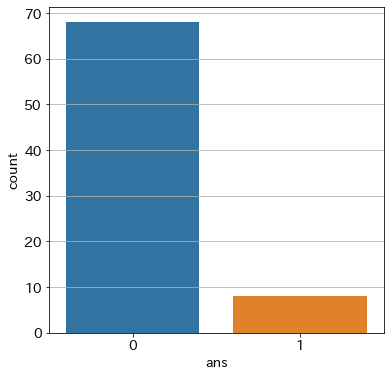

In [177]:
sns.countplot(x="ans", data=df_f)